In [1]:
# для обработки данных
import pandas as pd
import numpy as np
# для парсинга
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
import re
# import time
# import csv
# для лемматизации
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
from nltk import FreqDist
from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')
# для моделирования
from gensim.models import Phrases
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.ldamodel import LdaModel
# для построения графиков
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

%matplotlib inline

In [2]:
sns.set(
    font_scale=2,
    style='whitegrid',
    rc={'figure.figsize': (20, 7)}
)

## Функции

#### - для считывания данных

In [2]:
def wall_parser():
    token = '0da629350da629350da62935b60dd2bd8200da60da629355233580cc925888190d01861'
    api = 'https://api.vk.com/method/wall.get'
    version = 5.92
    domain = 'knife.media'
    offset = 0
    count = 100
    all_posts = []

    while offset < 9000:
        response = requests.get(api,
                                params = {'access_token': token,
                                          'v': version,
                                          'domain': domain,
                                          'count': count,
                                          'offset': offset}
                               )
        data = response.json()['response']['items']
        offset += count
        all_posts.extend(data)
    return all_posts

In [3]:
def filter_inf():
    filter_data_list = []
    all_posts = wall_parser()
    for post in all_posts:
        filter_data_list.append([post['id'],
                                 post['date'],
                                 post['likes']['count'],
                                 post['comments']['count'],
                                 post['reposts']['count'],
                                 post['views']['count'],
                                 post['text']])
    return filter_data_list

In [15]:
# локальная функция для получения комментариев комментариев
def getCom_l(token, api, version, owner_id, post_id, comm_id):
    
    offset = 0
    count = 1
    comments = []
    while offset < 100:
        response = requests.get(api,
                                params = {'access_token': token,
                                          'v': version,
                                          'owner_id': owner_id,
                                          'post_id': post_id,
                                          'count': count,
                                          'offset': offset,
                                          'comment_id': comm_id}
                               )
        try: 
            data = response.json()['response']['items'][0]
            comments.append([data['post_id'], data['id'], data['date'], data['text']])
        except:
            break
        offset += count

    return comments

In [16]:
# функция получения комментариев постов
def getCom(posts_id):
    token = '0da629350da629350da62935b60dd2bd8200da60da629355233580cc925888190d01861'
    api = 'https://api.vk.com/method/wall.getComments'
    version = 5.92
    owner_id = '-32943546'

    all_comments = []

    for post_id in posts_id:
        offset = 0
        count = 1
        while offset < 100:
            response = requests.get(api,
                                    params = {'access_token': token,
                                              'v': version,
                                              'owner_id': owner_id,
                                              'post_id': post_id,
                                              'count': count,
                                              'offset': offset}
                                   )
            try:
                data = response.json()['response']['items'][0]
                all_comments.append([data['post_id'], data['id'], data['date'], data['text']])
                all_comments.extend(getCom_l(token, api, version, owner_id, post_id, data['id']))
            except:
                break
            offset += count
    return all_comments

#### - для получения ссылок

In [6]:
# изменить шаблон под более общий !!!!!!!!!!
def try_url(x):
    pattern = r'(https://kn.+)|(http://knf.+)'
    try:
        return re.search(pattern, x)[0]
    except:
        return ('false')
# def try_url(x):
#     pattern = r'.*(http.+)'
#     try:
#         if re.findall(pattern, x)[0]:
#             return re.findall(pattern, x)[0]
#     except:
#         return ('false')

#### - для построения графиков

In [8]:
def get_plot(df, x_label, y_label, title):
    ax = df.plot()
    ax.set_title(title)
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    sns.despine()

#### - для предобработки текста

In [9]:
# функция парсинга текста
def text_parser(url):
    try:
        html = urlopen(url).read().decode('utf-8')
        # возможно, сделать шаблон более общим
        pattern_2 = r'.+"text":"(.+)"}</script>'
        text = re.findall(pattern_2, html)[0].replace(u'\xa0', ' ')
    except:
        text = ''
    return text
# возвращает строку текста страницы

In [10]:
def tags(link):
    tags_page = []
    try:
        html = urlopen(link).read().decode('utf-8')
        soup = BeautifulSoup(html,'html.parser')
        tags = soup.find_all(rel="tag")
        for tag in tags:
            tags_page.append(tag.text)
    except:
        tags_page = None
    return tags_page

In [11]:
# лемматизатор Mystem
morph_1 = Mystem()
def lemmatize_Mystem(text):
    lemmas = morph_1.lemmatize(text.lower())
    return ''.join(lemmas).strip()
#     возвращает строку слов

In [12]:
# список стопслов
stopwords_list = stopwords.words('russian')
listToAdd = ['который', 'весь', 'это', 'ваш', 'такой', 'свой', 'наш', 'самый', 'никто', 'однако', 'наверное', 'вскоре', 'сей']
stopwords_list.extend(listToAdd)
stopwords_list = set(stopwords_list)

In [13]:
# лемматизатор MorphAnalyzer
morph_2 = MorphAnalyzer()
def lemmatize_MorphAnalyzer(text):
#     words = text.lower().split() # разбиваем текст на слова
    words = lemmatize_Mystem(text).split()
    words_inf = []
    for word in words:
        if word not in stopwords_list:
            word_inf = morph_2.parse(word)[0].normal_form
            words_inf.append(word_inf)
    return words_inf
# используется после lemmatize_Mystem 
# возвращает список слов

In [14]:
def cleaner(link):
    text = text_parser(link)
    text = re.sub(r'[._^%$#!~@,-«»]+', ' ', text)
    text = re.sub('[^а-яА-Я ]', '', text)
    return text
# re.sub(r'(\<(/?[^>]+)>)', ' ', text_parser(url))

In [15]:
def keywords(texts):
    freq_list = []
    for text in texts:
        if text == '':
            freq_list.append(None)
            continue
        t3 = FreqDist(lemmatize_MorphAnalyzer(text))
        freq_list.append(t3.most_common(3))
    return freq_list


In [16]:
def norm_form(texts):
    texts_clean = []
    for text in texts:
        if text == '':
            texts_clean.append(['в'])
            continue
        texts_clean.append(lemmatize_MorphAnalyzer(text))
    return texts_clean
# возвращает список списков, где каждый список - слова в начальной форме отдельного текста без стопслов

## Считывание данных

In [7]:
columns = ['id', 'time', 'likes', 'comments', 'reposts', 'views', 'text']
df = pd.DataFrame(filter_inf(), columns = columns)

In [8]:
# считаем метрику, по которой можно будет оценивать качество поста
df['ctr'] = (df.likes / df.views * 100).round(2)

In [9]:
# запускаем функцию поиска ссылок статей в тексте поста, результат заносим в отдельную колонку
# false заносится, если ссылка не подходит под входной шаблон
df['url'] = df.text.apply(try_url)

In [10]:
# формируем колонку даты в необходимом формате
df['year'] = pd.to_datetime(df.time, unit='s').dt.to_period('Y')
df['month'] = pd.to_datetime(df.time, unit='s').dt.to_period('M')
df['day'] = pd.to_datetime(df.time, unit='s').dt.to_period('D')

In [21]:
df.head()

,id,time,likes,comments,reposts,views,text,ctr,url,year,month,day
0,319300,1604652365,55,30,16,10671,В этом году [club2049553|ЛГБТ-кинофестиваль Бо...,0.52,false,2020,2020-11,2020-11-06
1,319331,1604658545,56,4,1,5453,Благотворительная организация «Ночлежка» откры...,1.03,https://knife.media/free-shower/,2020,2020-11,2020-11-06
2,319292,1604650203,76,3,5,12699,"Максим Горький в детстве ненавидел книги, в юн...",0.60,https://knife.media/gorky-death/,2020,2020-11,2020-11-06
3,319290,1604649844,93,5,6,8650,Песни армяно-американской группы посвящены кон...,1.08,https://knife.media/soad-songs/,2020,2020-11,2020-11-06
4,319286,1604648402,27,5,4,10117,"Исследователи пришли к выводу, что художник, с...",0.27,https://knife.media/mental-problems-of-van-gogh/,2020,2020-11,2020-11-06


In [22]:
df.shape

(9000, 12)

### Фильтрация данных

In [18]:
# выбираем данные с фильтром по дате и с нужными ссылками
filtered_df = df.query("url != 'false' and day >= '2018-01-01'")
# quant_views = data_group_id.views.quantile(0.5)
# print(f'quant_views = {quant_views}')
# data_group_id = data_group_id.query("views >= @quant_views")

In [19]:
# columns = ['id', 'comm_id', 'date_com', 'comm_text']
# comments_df = pd.DataFrame(getCom(filtered_df.id), columns=columns)

In [20]:
comments_df.head()

,id,comm_id,date_com,comm_text
0,319368,319380,1604666988,"""предложили создали""\nВыберите одно из двух."
1,319368,319393,1604669415,напалм
2,319366,319369,1604665830,"«нужно было составлять расписание, в какой кро..."
3,319366,319370,1604666216,неплохо вы рехнулись там
4,319366,319372,1604666416,Псссс! Сегодня в эфире рубрика «Из жизни живот...


In [21]:
comments_df.shape

(106769, 4)

In [22]:
comments_df.to_csv('comments.csv', index=False)

In [212]:
# # запускаем функцию поиска тегов для каждого поста, результат возвращается в виде списка, для каждой записи
# filtered_df['tags'] = filtered_df.url.apply(tags)

C:\Users\anafem\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [215]:
filtered_df.isna().sum()

id           0
time         0
likes        0
comments     0
reposts      0
views        0
text         0
ctr          0
url          0
year         0
month        0
day          0
tags        41
dtype: int64

In [216]:
filtered_df.shape

(7773, 13)

In [217]:
# удаляем информацию о статьях, в которых нет тегов, т.к. в дальнейшем анализе мы будем использовать именно их
filtered_df.dropna(inplace=True)

C:\Users\anafem\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [218]:
filtered_df.shape[0]

7732

### Общий анализ

In [219]:
filtered_df.head()

,id,time,likes,comments,reposts,views,text,ctr,url,year,month,day,tags
0,318847,1604391003,220,13,14,42064,Учителя и мусорщики решают реальные проблемы. ...,0.52,https://knife.media/too-many-jobs/,2020,2020-11,2020-11-03,"[работа, будущее]"
1,319252,1604593980,8,0,2,4977,Святому Георгию недавно презентовали коробку с...,0.16,https://knife.media/votives/,2020,2020-11,2020-11-05,"[искусство, мир, религия]"
2,319222,1604588943,76,19,7,9532,Группы охотников в древних обществах предполож...,0.80,https://knife.media/powerful-huntress/,2020,2020-11,2020-11-05,"[женщины, исследование, история]"
3,319212,1604585403,83,4,4,12191,"«Красавица, 24 лет, интеллигентная, очень шика...",0.68,https://knife.media/history-dating/,2020,2020-11,2020-11-05,"[общение, история, любовь, россия]"
4,319181,1604578204,122,8,10,15181,Японская культура жестока к душевнобольным. Мн...,0.80,https://knife.media/japanese-psychiatry/,2020,2020-11,2020-11-05,"[япония, деньги, насилие, общество, поведение,..."


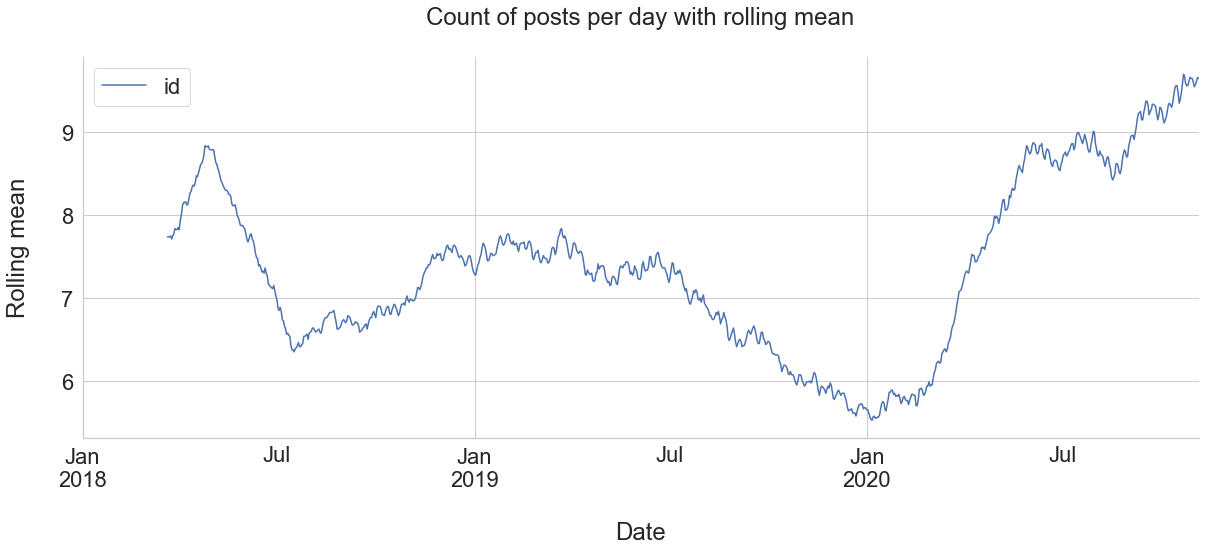

In [220]:
# # можно поместить 3 графика на 1 !!!!!!!
count_for_plot = filtered_df.groupby('day') \
    .agg({'id': 'count'}) \
    .rolling(80).mean() 
get_plot(count_for_plot, '\nDate', 'Rolling mean\n', 'Count of posts per day with rolling mean\n')

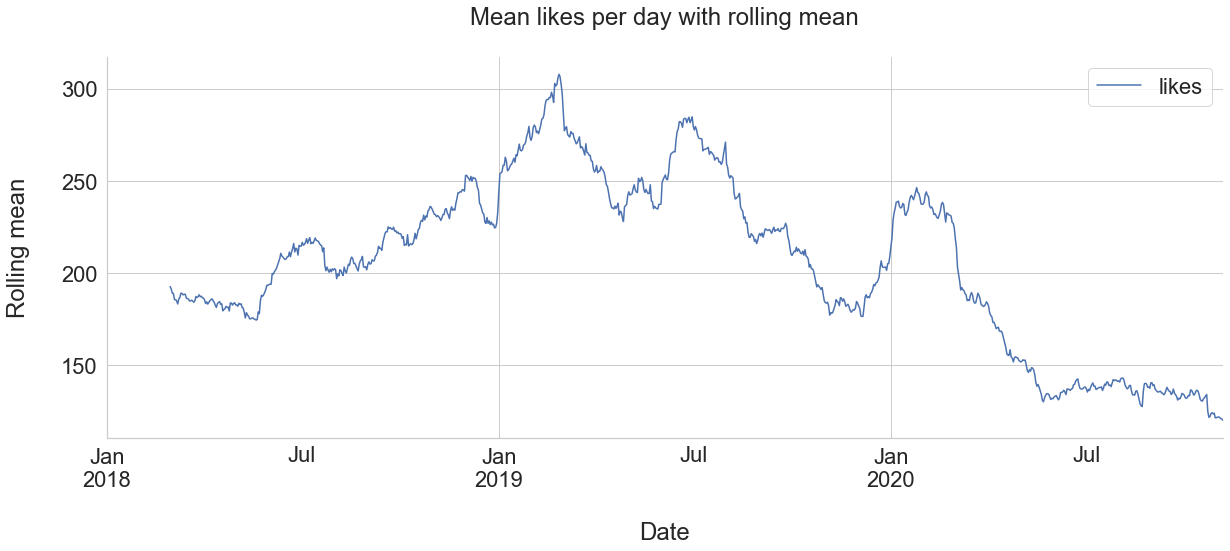

In [221]:
# реализовано "скользящее среднее" - распространенный прием для уменьшения зашумления, но сохранения основной динамики
likes_for_plot = filtered_df.groupby('day') \
    .agg({'likes': 'median'}) \
    .rolling(60).mean()

get_plot(likes_for_plot, '\nDate', 'Rolling mean\n', 'Mean likes per day with rolling mean\n')

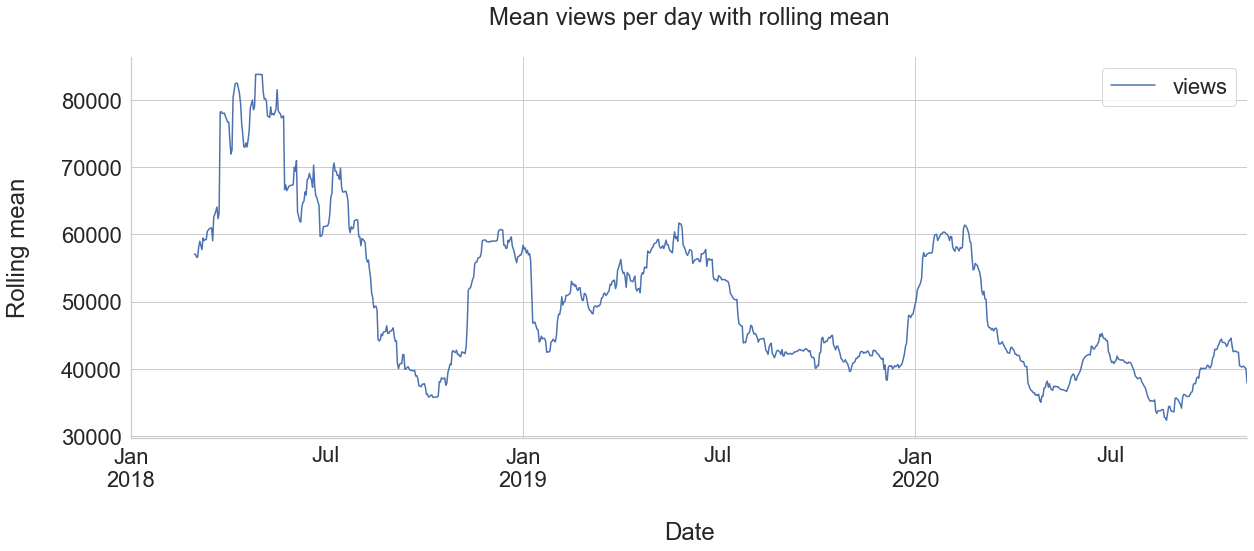

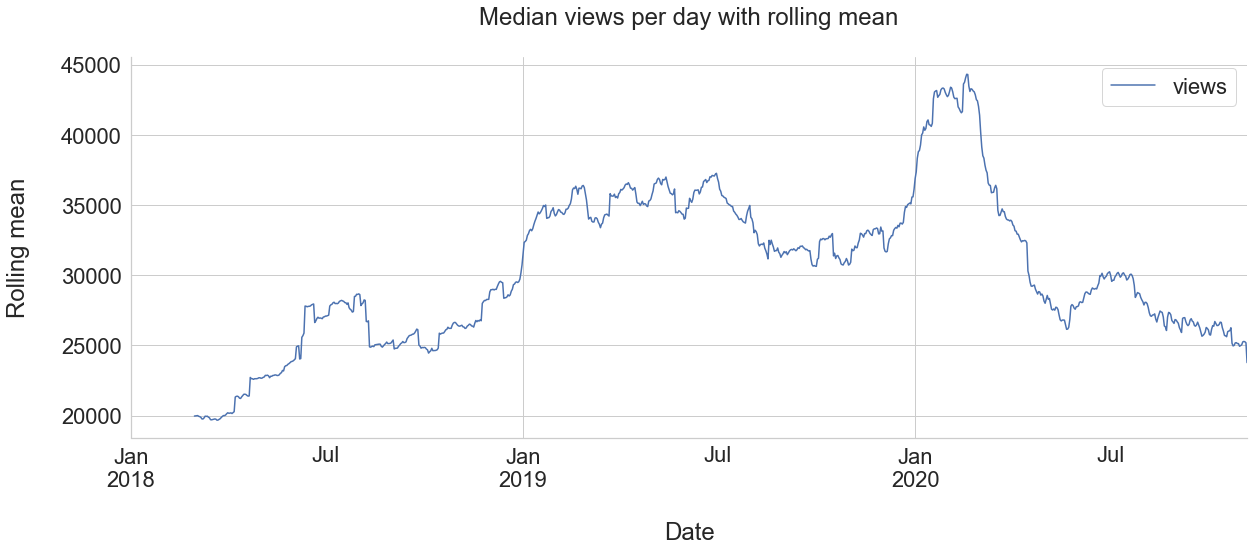

In [222]:
views_for_plot = filtered_df.groupby('day') \
    .agg({'views': 'mean'}) \
    .rolling(60).mean()

views_for_plot_ = filtered_df.groupby('day') \
    .agg({'views': 'median'}) \
    .rolling(60).mean()
get_plot(views_for_plot, '\nDate', 'Rolling mean\n', 'Mean views per day with rolling mean\n')
get_plot(views_for_plot_, '\nDate', 'Rolling mean\n', 'Median views per day with rolling mean\n')

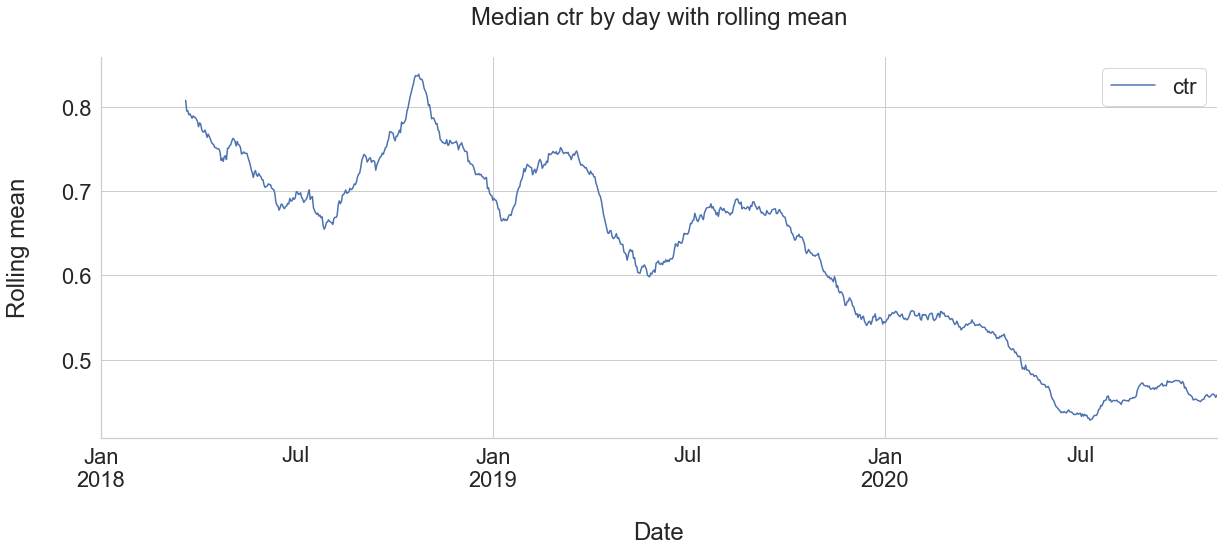

In [223]:
ctr_for_plot = filtered_df.groupby('day') \
    .agg({'ctr': 'median'}) \
    .rolling(80).mean() 

get_plot(ctr_for_plot, '\nDate', 'Rolling mean\n', 'Median ctr by day with rolling mean\n')

In [224]:
# большинство постов в 2018 году было с небольшим количеством просмотров
# но были посты с очень большим количеством просмотров, из-за которых наблюдается завышение среднего значения

In [225]:
# разбиваем списки тегов, чтобы в одной строке был один тег и записываем данные в файл
filtered_df.explode('tags').to_csv('filtered_data.csv', index=False)

## Анализ тегов

In [177]:
filtered_df = pd.read_csv('filtered_data.csv')

In [33]:
# посчитаем количество встречаемости тегов в статьях, найдём наиболее упоминаемые теги
freq_tags = filtered_df.tags.value_counts()
freq_tags = freq_tags.reset_index().rename(columns={'index': 'tags', 'tags': 'fraction'})

In [34]:
freq_tags.head()

,tags,fraction
0,россия,2189
1,общество,946
2,наука,880
3,психология,861
4,мир,803


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

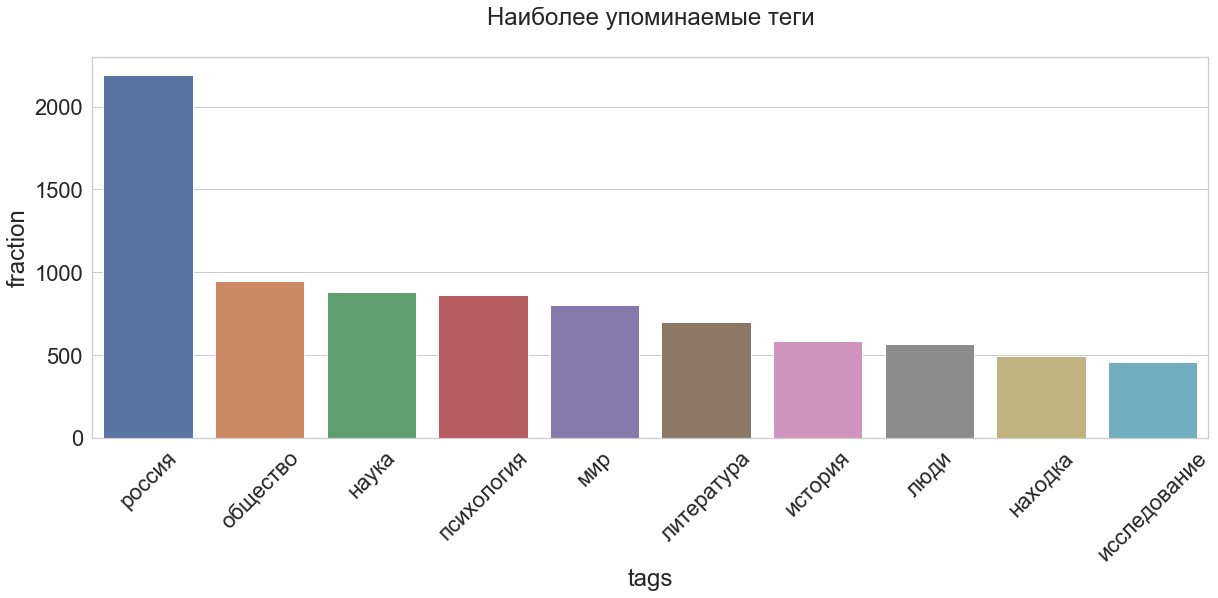

In [35]:
ax = sns.barplot(x=freq_tags.head(10).tags, y=freq_tags.head(10).fraction)
ax.set_title('Наиболее упоминаемые теги\n')
plt.xticks(rotation=45)
# это означает, что именно на эти темы было написано больше всего статей

In [141]:
# задаём порог q, по которому можно отобрать теги, которые встречаются достаточно часто,
# чтобы исключить те случаи, когда медианное значение ctr редких статей будет более высокий
# из-за этого можно сделать ошибочные выводы о качестве контента для конкретных тегов
perc = 0.30
q = freq_tags.fraction.quantile(perc)
df_tags_ctr = filtered_df.merge(freq_tags, on='tags').query("fraction >= @q")[['tags', 'ctr']]
print(f'Отберем теги, которые упоминались хотя бы в {int(q)} статьях. Это {int((1-perc)*100)}% тегов от их общего числа.')

Отберем теги, которые упоминались хотя бы в 54 статьях. Это 70% тегов от их общего числа.


In [142]:
# посчитано медианное значение ctr для той части тегов, частота встречаемости в статьях которых выше, чем в оставшейся части
tags_median_ctr = df_tags_ctr.groupby('tags', as_index=False) \
    .agg({'ctr': 'median'}) \
    .sort_values('ctr', ascending=False) \
    .rename(columns={'ctr': 'median_ctr'})

In [143]:
# лучшие и худшие теги статей за всё время по медианному значению ctr
best_tags_median_ctr = tags_median_ctr.head(10)
bad_tags_median_ctr = tags_median_ctr.tail(10)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

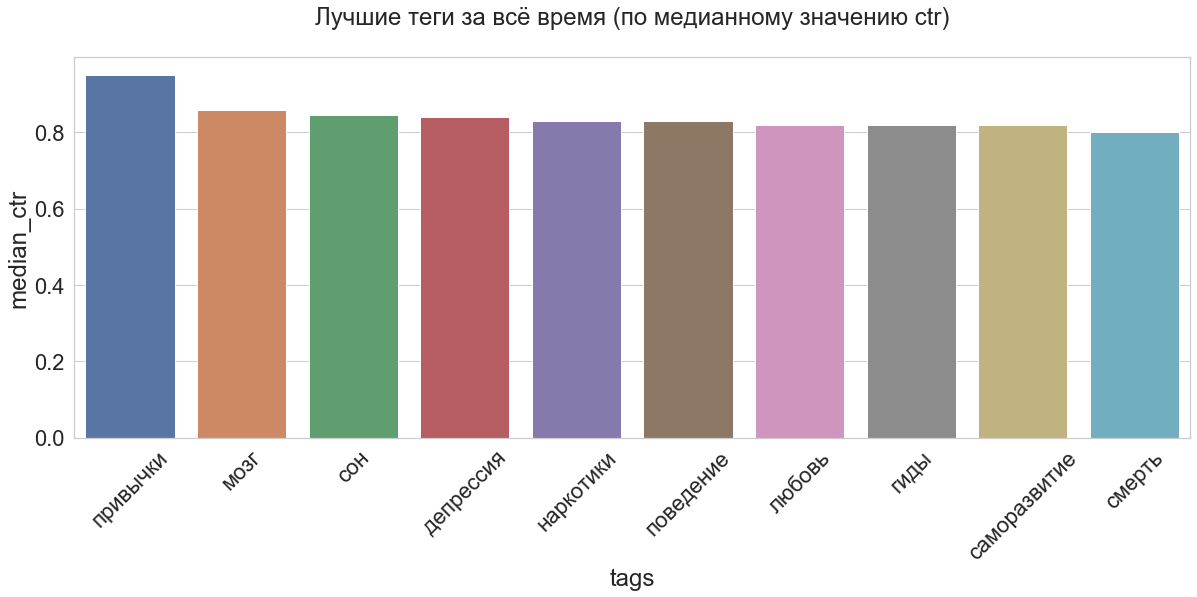

In [144]:
ax = sns.barplot(x=best_tags_median_ctr.tags, y=best_tags_median_ctr.median_ctr)
ax.set_title('Лучшие теги за всё время (по медианному значению ctr)\n')
plt.xticks(rotation=45) 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

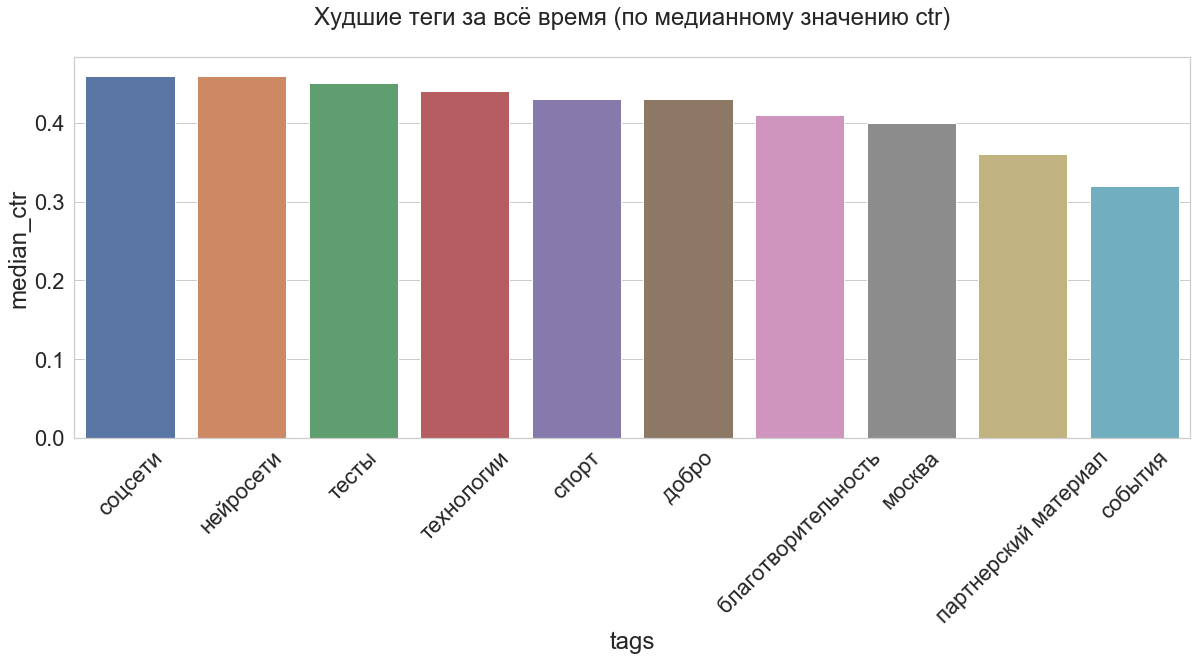

In [145]:
ax = sns.barplot(x=bad_tags_median_ctr.tags, y=bad_tags_median_ctr.median_ctr)
ax.set_title('Худшие теги за всё время (по медианному значению ctr)\n')
plt.xticks(rotation=45) 

### Отбор лучших и худших постов

In [41]:
# # 25% постов имеют лайков больше, чем quant_likes
# quant_likes = data_group_id.likes.quantile(0.75)
# print(f'quant_likes = {quant_likes}')
# # 25% постов имеют репостов больше, чем quant_reposts
# quant_reposts = data_group_id.reposts.quantile(0.75)
# print(f'quant_reposts = {quant_reposts}')
# 50% постов имеют просмотров больше, чем quant_views
quant_views = data_group_id.views.quantile(0.5)
print(f'quant_views = {quant_views}')
# отбор более представительных статей
data_group_id = data_group_id.query("views >= @quant_views")

quant_views = 25532.0


In [42]:
best_posts_ctr = data_group_id.sort_values('ctr', ascending=False).head(100)
bad_posts_ctr = data_group_id.sort_values('ctr', ascending=False).tail(100)

In [43]:
best_posts_ctr.head()

,id,time,likes,comments,reposts,views,url,ctr
date,,,,,,,,
2018-06-29,173740,1530266978,808,20,72,31131,https://knife.media/the-funniest-films/,2.60
2018-02-15,153993,1518667206,727,20,50,28670,http://knf.md/story-infantile,2.54
2018-06-18,171929,1529322159,683,44,47,27569,https://knife.media/30-best-directors/,2.48
2018-06-27,173406,1530096359,1079,32,117,44131,https://knife.media/fragile-generation/,2.44
2018-09-13,185392,1536858252,1124,27,83,46212,https://knife.media/psychosomatics/,2.43


In [44]:
# best_posts_url = list(best_posts_ctr.url)
# bad_posts_url = list(bad_posts_ctr.url)

In [45]:
# best_clean_text = cleaner(best_posts_url)
# bad_clean_text = cleaner(bad_posts_url)

In [46]:
# best_posts_ctr['keywords'] = keywords(best_clean_text)
best_posts_ctr['tags'] = best_posts_ctr.url.apply(tags)
best_posts_ctr = best_posts_ctr.explode('tags')

In [47]:
best_posts_ctr.to_csv('best_posts.csv', index=False)

In [48]:
# bad_posts_ctr['keywords'] = keywords(bad_clean_text)
bad_posts_ctr['tags'] = bad_posts_ctr.url.apply(tags)
bad_posts_ctr = bad_posts_ctr.explode('tags')

In [49]:
bad_posts_ctr.to_csv('bad_posts.csv', index=False)

### Анализ тегов лучших постов

In [50]:
best_posts_ctr = pd.read_csv('best_posts.csv')
# best_posts_ctr['year'] = pd.to_datetime(best_posts_ctr.time, unit='s').dt.to_period('Y')

In [51]:
best_posts_ctr.head()

,id,time,likes,comments,reposts,views,url,ctr,tags
0,145839,1514826660,505,11,18,25752,http://knf.md/money-2-vk,1.96,деньги
1,145839,1514826660,505,11,18,25752,http://knf.md/money-2-vk,1.96,привычки
2,145839,1514826660,505,11,18,25752,http://knf.md/money-2-vk,1.96,психология
3,147645,1515443643,575,21,24,28905,http://knf.md/barnet-cats,1.99,женщины
4,147645,1515443643,575,21,24,28905,http://knf.md/barnet-cats,1.99,коты


In [52]:
print('Общее количество тегов в лучших статьях = {}'.format(best_posts_ctr.tags.count()))

Общее количество тегов в лучших статьях = 349


In [53]:
print(f'Количество уникальных тегов в лучших статьях = {best_posts_ctr.tags.nunique()}')

Количество уникальных тегов в лучших статьях = 72


In [54]:
best_tags = best_posts_ctr.tags.value_counts()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

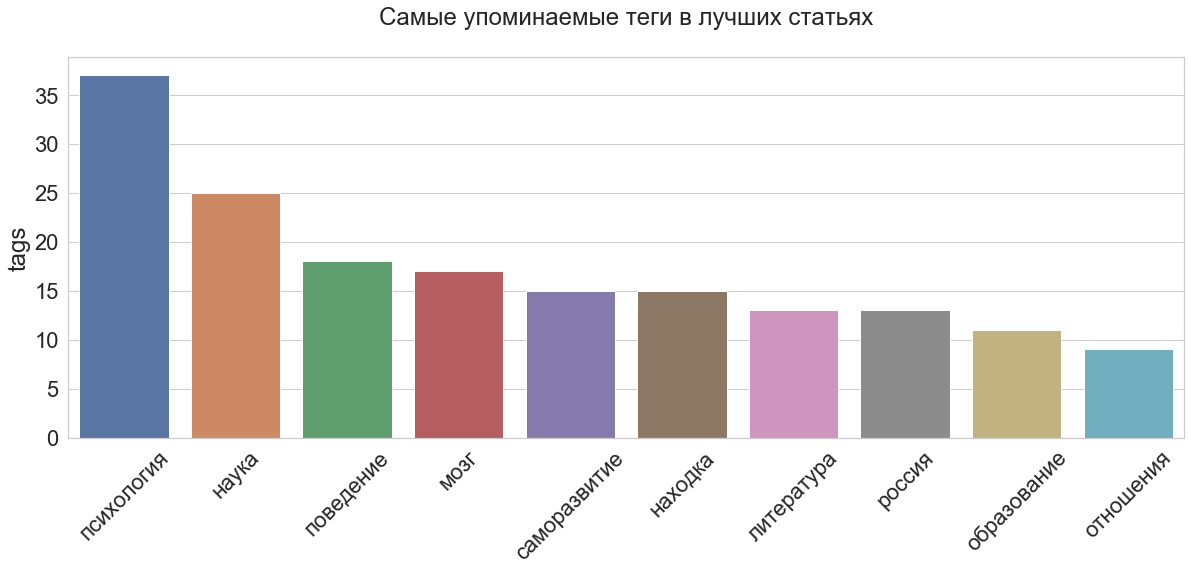

In [55]:
top_best_tags = best_tags.head(10)
ax = sns.barplot(x=top_best_tags.index, y=top_best_tags)
ax.set_title('Самые упоминаемые теги в лучших статьях\n')
plt.xticks(rotation=45) 

In [56]:
# необходимо отобрать в лучших статьях самые характерные теги, 
# которые упоминаются достаточное количество раз и имеют высокое медианное значение ctr (потому как 

In [57]:
best_tags = best_tags.reset_index() \
    .rename(columns={'index': 'tags', 'tags': 'fraction'})

In [58]:
best_tags.head(15)

,tags,fraction
0,психология,37
1,наука,25
2,поведение,18
3,мозг,17
4,саморазвитие,15
5,находка,15
6,литература,13
7,россия,13
8,образование,11
9,отношения,9


In [59]:
perc = 0.88
q = best_tags.fraction.quantile(perc)
df_tags_ctr = best_posts_ctr.merge(best_tags, on='tags').query("fraction >= @q")[['tags', 'ctr']]
print(f'Отберем теги, которые упоминались хотя бы в {q} статьях. Это ~{int((1-perc)*100)}% тегов от их общего числа.')

Отберем теги, которые упоминались хотя бы в 9.959999999999994 статьях. Это ~12% тегов от их общего числа.


In [60]:
best_tags_median_ctr = df_tags_ctr.groupby('tags', as_index=False) \
    .agg({'ctr': 'median'}) \
    .sort_values('ctr', ascending=False) \
    .rename(columns={'ctr': 'median_ctr'})

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

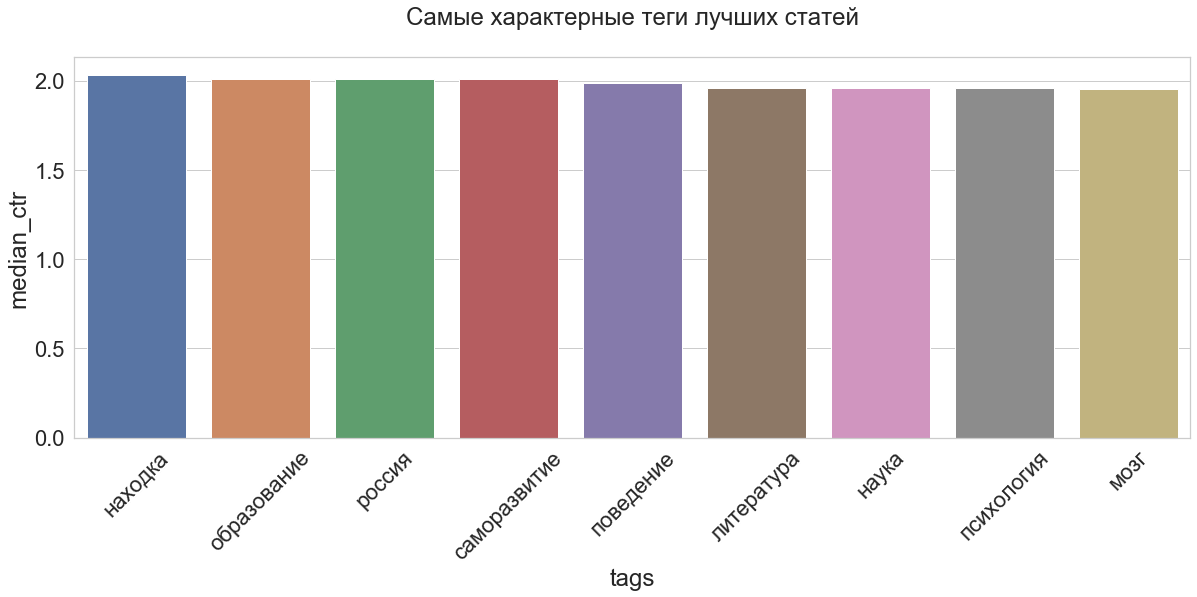

In [61]:
ax = sns.barplot(x=best_tags_median_ctr.tags, y=best_tags_median_ctr.median_ctr)
ax.set_title('Самые характерные теги лучших статей\n')
plt.xticks(rotation=45) 

In [62]:
# психология - самый популярный жанр среди лучших постов
# однако так может быть из-за того, что в целом статей по психологии больше, чем остальных

In [63]:
# # посчитаем медианный ctr для каждого тега, отсортируем и посмотрик, какие теги среди лучших постов по ctr более качественные
# median_ctr_best_tags = best_posts_ctr.groupby('tags', as_index=False) \
#     .agg({'ctr': 'median'}) \
#     .rename(columns={'ctr': 'median_ctr'}) \
#     .sort_values('median_ctr', ascending=False).head(10)

In [64]:
# sns.barplot(x=median_ctr_best_tags.tags, y=median_ctr_best_tags.median_ctr)
# plt.xticks(rotation=45) 

### Анализ тегов худших постов

In [65]:
bad_posts_ctr = pd.read_csv('bad_posts.csv')
# bad_posts_ctr['year'] = pd.to_datetime(bad_posts_ctr.time, unit='s').dt.to_period('Y')

In [66]:
bad_posts_ctr.head()

,id,time,likes,comments,reposts,views,url,ctr,tags
0,153531,1518449356,367,1,41,532466,http://knf.md/leadersofrussia-final,0.07,будущее
1,153531,1518449356,367,1,41,532466,http://knf.md/leadersofrussia-final,0.07,люди
2,153531,1518449356,367,1,41,532466,http://knf.md/leadersofrussia-final,0.07,политика
3,153531,1518449356,367,1,41,532466,http://knf.md/leadersofrussia-final,0.07,россия
4,158453,1520947007,571,6,14,590791,https://knife.media/word-timeline/,0.10,находка


In [67]:
print('Общее количество тегов в худших статьях = {}'.format(bad_posts_ctr.tags.count()))

Общее количество тегов в худших статьях = 389


In [68]:
count_utag = bad_posts_ctr.tags.nunique()
print(f'Количество различных тегов в худших статьях = {count_utag}')

Количество различных тегов в худших статьях = 80


In [69]:
bad_tags = bad_posts_ctr.tags.value_counts()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

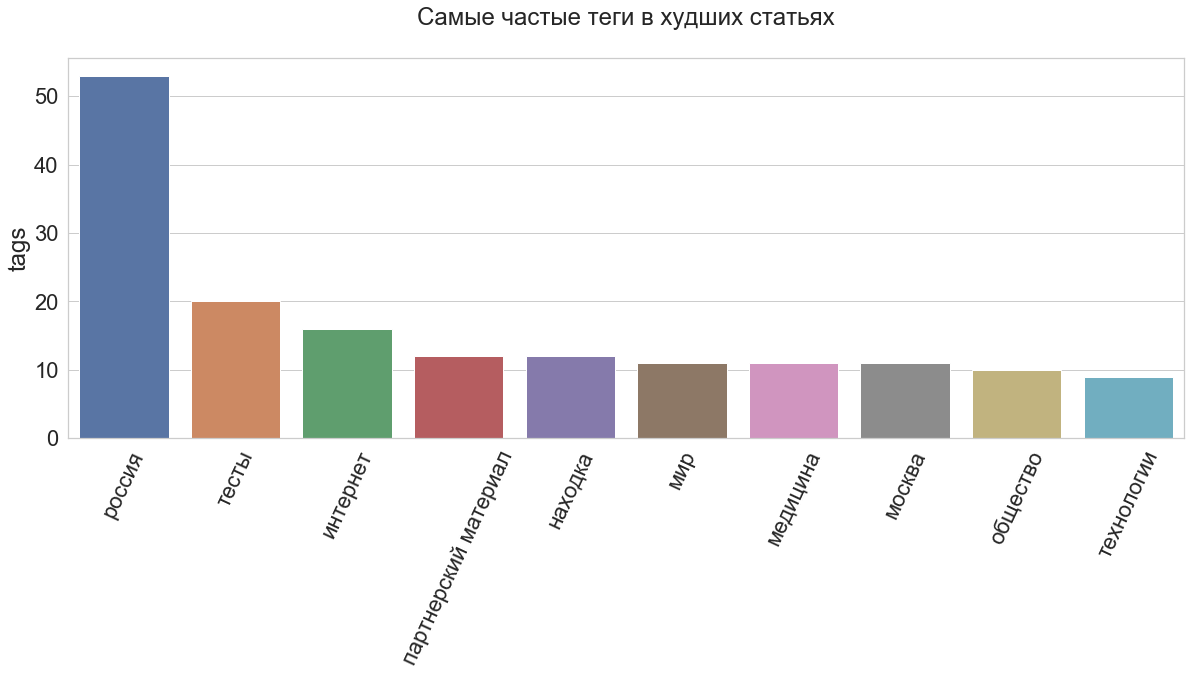

In [70]:
top_bad_tags = bad_tags.head(10)
ax = sns.barplot(x=top_bad_tags.index, y=top_bad_tags)
ax.set_title('Самые частые теги в худших статьях\n')
plt.xticks(rotation=65) 

In [71]:
bad_tags = bad_tags.reset_index() \
    .rename(columns={'index': 'tags', 'tags': 'fraction'})

In [72]:
bad_tags.head(15)

,tags,fraction
0,россия,53
1,тесты,20
2,интернет,16
3,партнерский материал,12
4,находка,12
5,мир,11
6,медицина,11
7,москва,11
8,общество,10
9,технологии,9


In [73]:
perc = 0.9
q = bad_tags.fraction.quantile(perc)
df_tags_ctr = bad_posts_ctr.merge(bad_tags, on='tags').query("fraction >= @q")[['tags', 'ctr']]
print(f'Отберем теги, которые упоминались хотя бы в {q} статьях. Это ~{int((1-perc)*100)}% тегов от их общего числа.')

Отберем теги, которые упоминались хотя бы в 10.100000000000009 статьях. Это ~9% тегов от их общего числа.


In [74]:
bad_tags_median_ctr = df_tags_ctr.groupby('tags', as_index=False) \
    .agg({'ctr': 'median'}) \
    .sort_values('ctr') \
    .rename(columns={'ctr': 'median_ctr'})

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

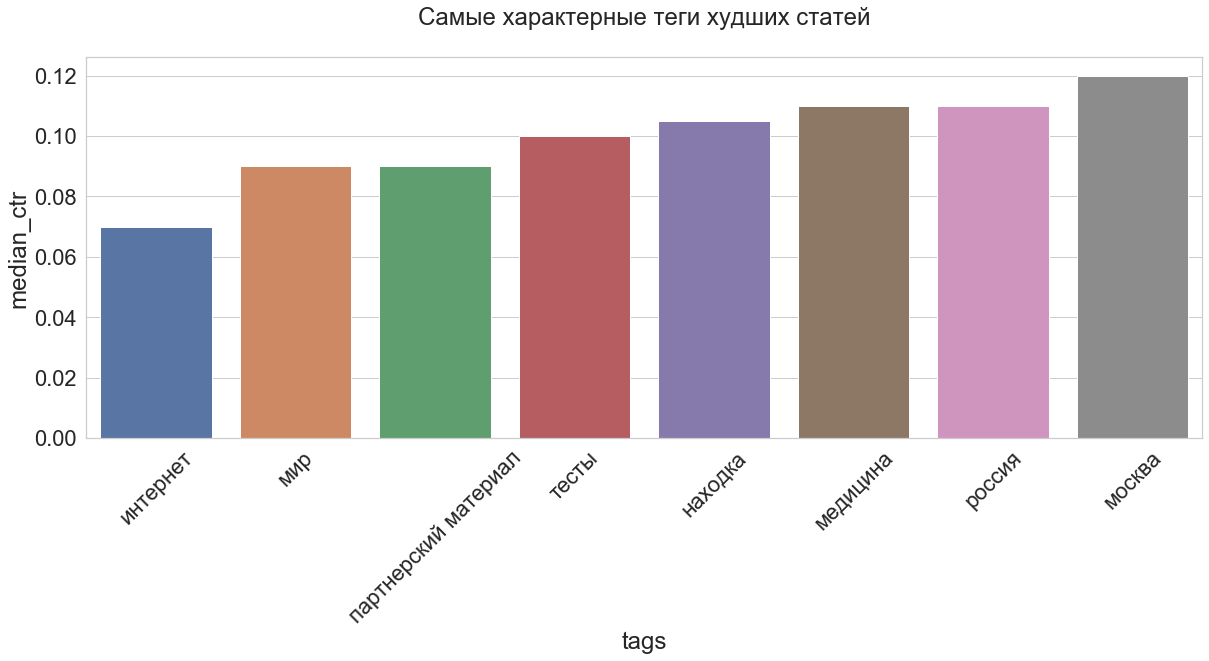

In [75]:
ax = sns.barplot(x=bad_tags_median_ctr.tags, y=bad_tags_median_ctr.median_ctr)
ax.set_title('Самые характерные теги худших статей\n')
plt.xticks(rotation=45) 

In [76]:
best_tags_median_ctr

,tags,median_ctr
3,находка,2.030
4,образование,2.010
7,россия,2.010
8,саморазвитие,2.010
5,поведение,1.985
0,литература,1.960
2,наука,1.960
6,психология,1.960
1,мозг,1.950


In [77]:
bad_tags_median_ctr

,tags,median_ctr
0,интернет,0.070
2,мир,0.090
5,партнерский материал,0.090
7,тесты,0.100
4,находка,0.105
1,медицина,0.110
6,россия,0.110
3,москва,0.120


In [78]:
print('Общие темы лучших и худших статей:', end=' ')
print(*bad_tags_median_ctr.loc[bad_tags_median_ctr.tags.isin(best_tags_median_ctr.tags)].tags, sep=', ', end='.')

Общие темы лучших и худших статей: находка, россия.

In [79]:
# далее можно отобрать статьи с общими темами из списка лучших статей и худших 
# в них можно выделить ключевые слова и понять, чем они отличаются

### Сравненительный анализ совпадающих характерных тегов лучших и худших статей

### Тег: россия

In [128]:
best_common_topic_russia = best_posts_ctr.query("tags == 'россия'")

In [129]:
best_common_topic_russia['tags'] = best_common_topic_russia.url.apply(tags)

C:\Users\anafem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###### другие теги в лучших статьях

In [133]:
best_common_topic_russia.explode('tags').query("tags != 'россия'").tags.value_counts().head()

образование     6
находка         5
интернет        3
саморазвитие    2
искусство       2
Name: tags, dtype: int64

In [134]:
bad_common_topic_russia = bad_posts_ctr.query("tags == 'россия'")

In [137]:
bad_common_topic_russia['tags'] = bad_common_topic_russia.url.apply(tags)

C:\Users\anafem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###### другие теги в худших статьях

In [140]:
bad_common_topic_russia.explode('tags').query("tags != 'россия'").tags.value_counts().head()

москва                  9
партнерский материал    7
тесты                   7
бизнес                  6
медицина                6
Name: tags, dtype: int64

### Тег: находка

###### другие теги в лучших статьях

In [168]:
g = best_posts_ctr.query("tags == 'находка'")

In [170]:
g['tags'] = g.url.apply(tags)

C:\Users\anafem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [173]:
g.explode('tags').query("tags != 'находка'").tags.value_counts().head()

образование     6
россия          5
кино            5
саморазвитие    2
литература      2
Name: tags, dtype: int64

###### другие теги в худших статьях

In [174]:
g = bad_posts_ctr.query("tags == 'находка'")

In [175]:
g['tags'] = g.url.apply(tags)

C:\Users\anafem\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [176]:
g.explode('tags').query("tags != 'находка'").tags.value_counts().head()

тесты     6
россия    4
языки     3
еда       2
музыка    2
Name: tags, dtype: int64

In [ ]:
def plotWordCloud(topic_number):
#     получаем частоты и слова топика
    text = dict(lda_30_topics[topic_number][1])
#     строим облако слов
    wordcloud = WordCloud(background_color='white', max_words=7, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(15, 10))
    plt.title('Топик номер {}'.format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [37]:
bad_clean_text = list(cleaner(row.url) for row in bad_posts_ctr.itertuples())

## Анализ различий тегов по годам

In [66]:
print(f'Количество уникальных тегов: {filtered_df.tags.nunique()}')

Количество уникальных тегов: 129


In [122]:
# количество уникальных тего по годам
filtered_df.resample('A').tags.nunique()

date
2018-12-31    126
2019-12-31    125
2020-12-31    125
Freq: A-DEC, Name: tags, dtype: int64

In [123]:
unique_tags_2018 = filtered_df.resample('A').tags.unique().loc['2018-12-31']
unique_tags_2019 = filtered_df.resample('A').tags.unique().loc['2019-12-31']
unique_tags_2020 = filtered_df.resample('A').tags.unique().loc['2020-12-31']

In [127]:
l = []
print("Теги, которые только в 2018:")
for i in unique_tags_2018:
    if i not in unique_tags_2019 and i not in unique_tags_2020:
        l.append(i)
print(*l, sep=', ', end='\n')

l = []
print('\nТеги, которые только в 2019:')
for i in unique_tags_2019:
    if i not in unique_tags_2018 and i not in unique_tags_2020:
        l.append(i)
print(*l, sep=', ', end='\n')

l = []
print('\nТеги, которые только в 2020:')
for i in unique_tags_2020:
    if i not in unique_tags_2019 and i not in unique_tags_2018:
        l.append(i)
print(*l, sep=', ')

Теги, которые только в 2018:
криптовалюты, зомби, вднх

Теги, которые только в 2019:
нож

Теги, которые только в 2020:
покупки


In [67]:
tags_years = filtered_df.resample('A').tags.value_counts(normalize=True)
tags_years = tags_years.to_frame().rename(columns={'tags': 'fraction'}).reset_index()

In [ ]:
tags_2018 = tags_years.loc[tags_years.date == '2018-12-31']

In [102]:
tags_2018.head()

,date,tags,fraction
0,2018-12-31,россия,0.114156
1,2018-12-31,наука,0.040914
2,2018-12-31,находка,0.032201
3,2018-12-31,литература,0.030559
4,2018-12-31,общество,0.030054


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

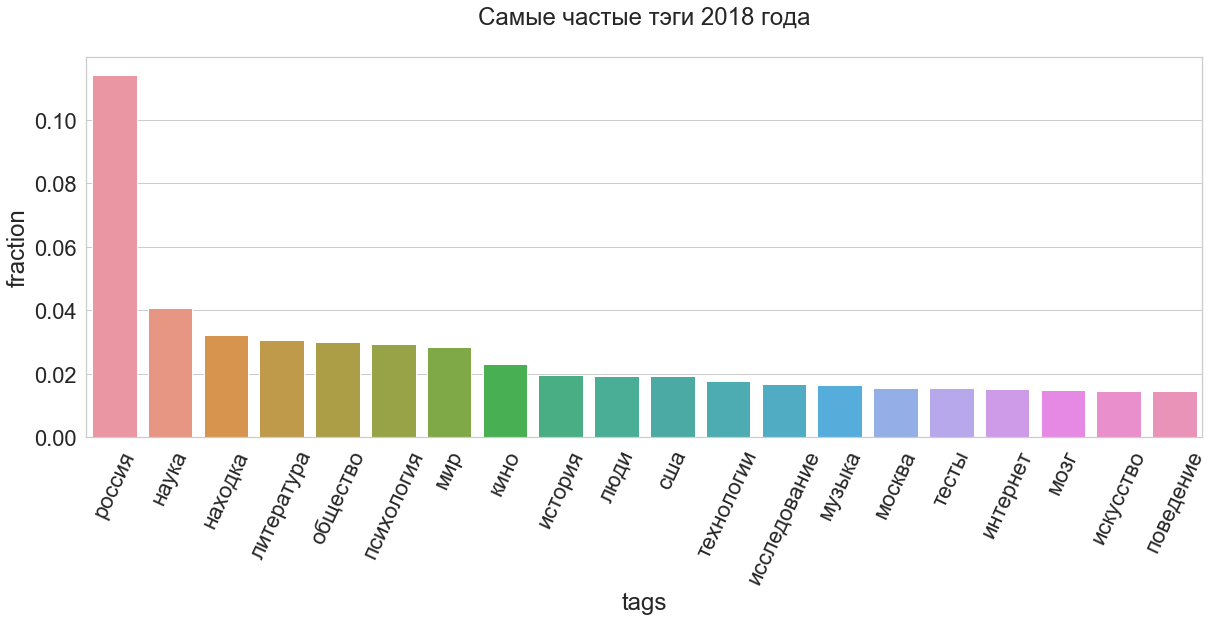

In [97]:
df = tags_2018.head(20)
ax = sns.barplot(x=df.tags, y=df.fraction)
ax.set_title('Самые частые тэги 2018 года\n')
plt.xticks(rotation=65) 

In [98]:
tags_2019 = tags_years.loc[tags_years.date == '2019-12-31']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

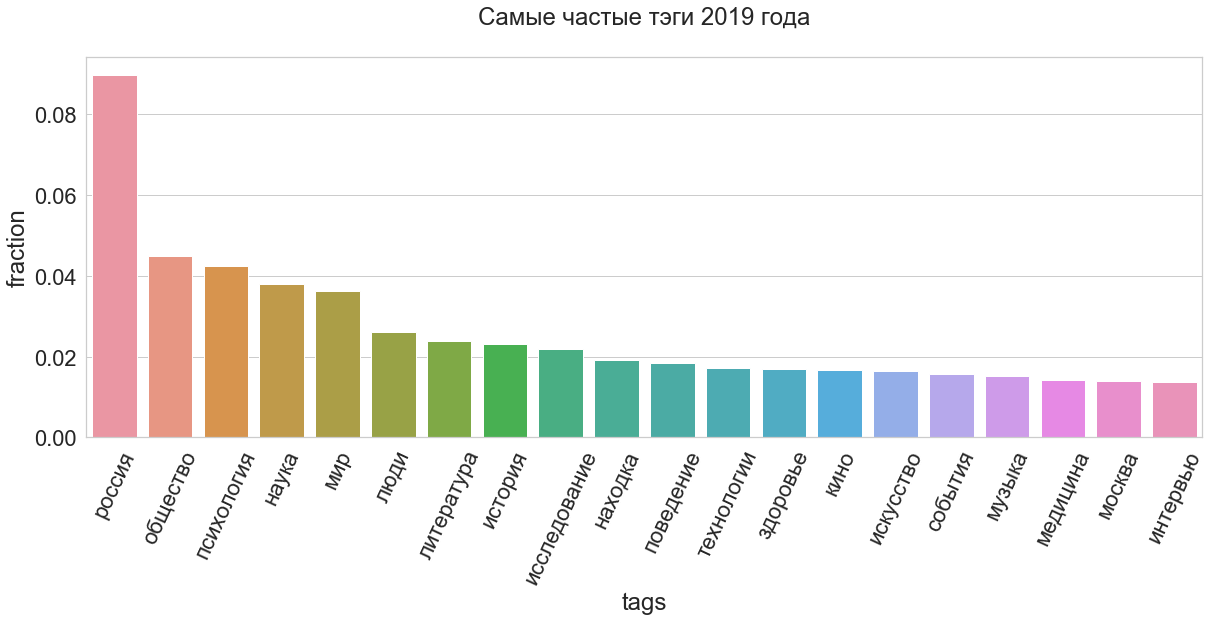

In [99]:
df = tags_2019.head(20)
ax = sns.barplot(x=df.tags, y=df.fraction)
ax.set_title('Самые частые тэги 2019 года\n')
plt.xticks(rotation=65) 

In [ ]:
tags_2020 = tags_years.loc[tags_years.date == '2020-12-31']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text xticklabel objects>)

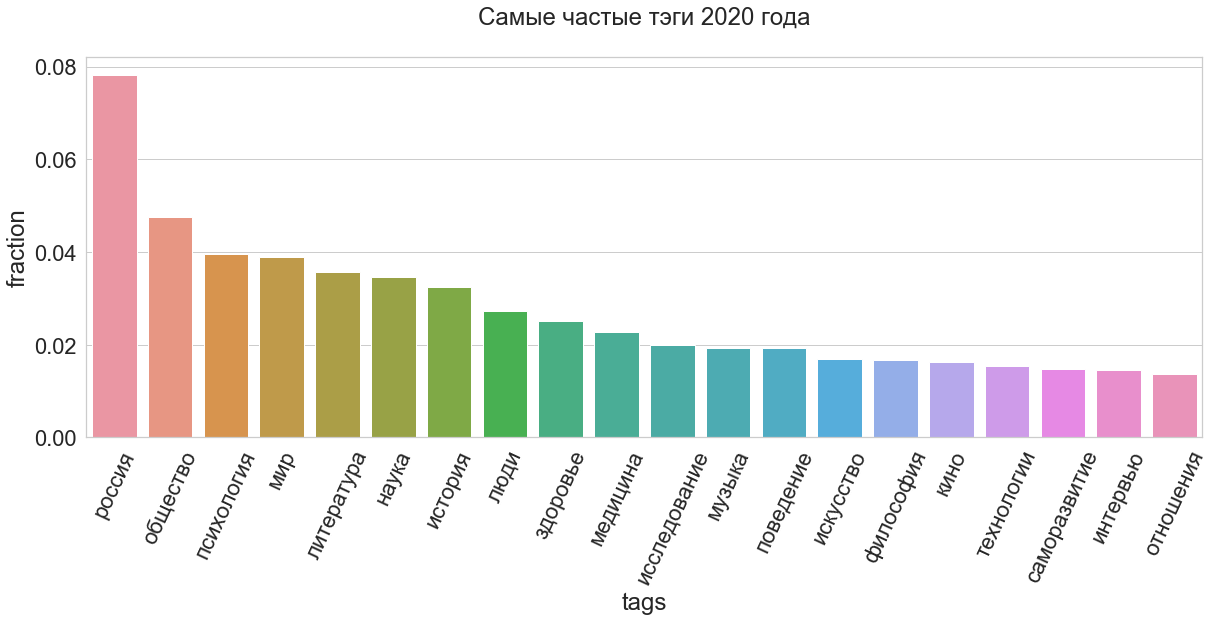

In [100]:
df = tags_2020.head(20)
ax = sns.barplot(x=df.tags, y=df.fraction)
ax.set_title('Самые частые тэги 2020 года\n')
plt.xticks(rotation=65) 

## Предобработка текста

In [142]:
best_texts = norm_form(best_clean_text)

In [143]:
print(f'Количество лучших текстов равно {len(best_texts)}')

Количество лучших текстов равно 100


In [144]:
best_texts[7]

['в']

In [248]:
bigram = Phrases(texts_clean, min_count=5, threshold=100) # Создаем биграммы на основе корпуса
trigram = Phrases(bigram[texts_clean], threshold=100)

In [ ]:
bigram = gensim.models.Phrases(texts_clean, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
def make_bigram(texts):
    return [bigram_mod[doc] for doc in texts]

In [ ]:
texts_clean = make_bigram(texts_clean)

In [249]:
for i in range(len(texts_clean)):
    for token in bigram[texts_clean[i]]:
        if '_' in token:
# Токен это би грамма, добавим в документ.
            texts_clean[i].append(token)
    for token in trigram[texts_clean[i]]:
        if '_' in token:
# Токен это три грамма, добавим в документ.
            texts_clean[i].append(token)

## Выделение темы

In [154]:
dictionary = Dictionary(best_texts)
dictionary.filter_extremes(no_below=9, no_above=0.1, keep_n=3*10**6)
# no_below, чтобы отфильтровать слова, встречающиеся менее _ раз
# no_above, чтобы отфильтровать слова, встречающиеся более чем в _% всех документов.
#Создадим словарь и корпус для lda модели
corpus = [dictionary.doc2bow(doc) for doc in best_texts]
print('Количество уникальных токенов: %d' % len(dictionary))
print('Количество документов: %d' % len(corpus))

Количество уникальных токенов: 231
Количество документов: 100


In [155]:
model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=4)
# model = LdaModel(corpus, id2word=dictionary, num_topics=4)
model.show_topics()

[(0,
  '0.032*"расстройство" + 0.021*"алкоголь" + 0.015*"животное" + 0.015*"психический" + 0.014*"психиатр" + 0.013*"свободный" + 0.013*"практиковать" + 0.010*"психотерапевт" + 0.010*"кофе" + 0.009*"стимул"'),
 (1,
  '0.023*"внешность" + 0.020*"сигнал" + 0.018*"форум" + 0.017*"потребление" + 0.016*"письмо" + 0.012*"удар" + 0.012*"женский" + 0.012*"рок" + 0.012*"расстройство" + 0.010*"случайный"'),
 (2,
  '0.024*"сын" + 0.013*"расстройство" + 0.010*"твой" + 0.010*"потребление" + 0.009*"сигнал" + 0.008*"население" + 0.008*"психический" + 0.008*"вознаграждение" + 0.008*"лидер" + 0.007*"симптом"'),
 (3,
  '0.021*"логический" + 0.019*"социолог" + 0.019*"философский" + 0.015*"ассоциация" + 0.014*"утверждение" + 0.014*"техника" + 0.013*"зачастую" + 0.013*"предположение" + 0.013*"лидер" + 0.012*"го"')]

In [ ]:
def plotWordCloud(topic_number):
#     получаем частоты и слова топика
    text = dict(lda_30_topics[topic_number][1])
#     строим облако слов
    wordcloud = WordCloud(background_color='white', max_words=7, width=900, height=900, collocations=False)
    wordcloud = wordcloud.generate_from_frequencies(text)
    plt.figure(figsize=(15, 10))
    plt.title('Топик номер {}'.format(topic_number))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

In [430]:
from wordcloud import WordCloud, STOPWORDS

IndexError: list index out of range

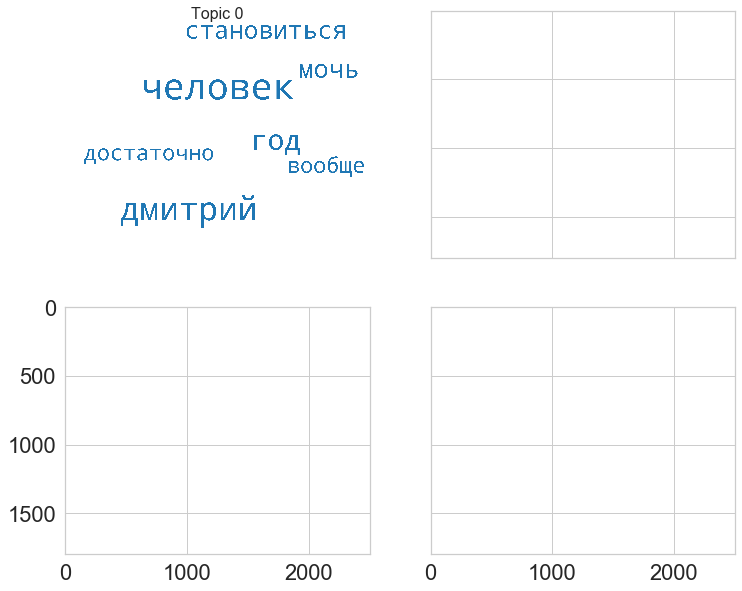

In [431]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords=stopwords_list,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=7,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [53]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [54]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=model, corpus=corpus, texts=texts_clean)

In [55]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_no', 'dominant_topic', 'topic_perc_contrib', 'keywords', 'text']

In [58]:
df_dominant_topic.head(25)

,document_no,dominant_topic,topic_perc_contrib,keywords,text
0,0,0.0,0.9578,"рассуждение, тело, россия, наука, секс, текст,...","[элиезер, юдковскийгарри, поттер, метод, рацио..."
1,1,3.0,0.9929,"дмитрий, тело, ребёнок, секс, женщина, спать, ...","[надоедать, смотреть, артхаус, монгольский, хо..."
2,2,1.0,0.9977,"ребёнок, дмитрий, взрослый, игра, родитель, ро...","[детство, важный, этап, каждый, человек, сложн..."
3,3,3.0,0.9631,"дмитрий, тело, ребёнок, секс, женщина, спать, ...","[портал, называть, режиссёр, снимать, плохой, ..."
4,4,1.0,0.9991,"ребёнок, дмитрий, взрослый, игра, родитель, ро...","[скверный, политика, параноидальный, родительс..."
5,5,2.0,0.9182,"ребёнок, тело, дмитрий, текст, секс, читатель,...","[почему, женщина, патриархальный, уклад, двига..."
6,6,3.0,0.7272,"дмитрий, тело, ребёнок, секс, женщина, спать, ...","[спать, короткий, промежуток, время, полностью..."
7,7,2.0,0.6198,"ребёнок, тело, дмитрий, текст, секс, читатель,...","[ссылка, работать]"
8,8,1.0,0.9653,"ребёнок, дмитрий, взрослый, игра, родитель, ро...","[октябрь, грузия, запрещаться, производство, и..."
9,9,0.0,0.9983,"рассуждение, тело, россия, наука, секс, текст,...","[рассуждать, каждый, день, знание, мир, рождат..."


In [221]:
# самый представительный текст каждой темы
pd.options.display.max_colwidth = 100
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)
# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]
# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9912,"интеллект, рожать, сигнал, разделять, земля, разумный, финансовый, заключаться, скучный, произво...","[стивен, хокинг, физик, изменять, представление, вселенная, учёный, успевать, заканчивать, главн..."
1,1.0,0.9861,"выступать, эволюция, позитивный, периодически, смеяться, стратегия, родный, вдохновлять, гдеть, ...","[отношение, обезьяна, иметь, война, притеснение, преступность, расизм, спам, электронный, почта,..."
2,2.0,0.9838,"концепция, сигнал, зачастую, лидер, скорость, безумный, интеллект, прошлый, банальный, выступление","[харизматик, править, главный, лиса, мир, убеждать, поверять, бог, работать, выходной, избирать,..."
3,3.0,0.9847,"ценность, практиковать, тёмный, скрывать, ньюйорк, земля, воспоминание, нерв, обладать, ранний","[говорить, медитация, мало, становиться, известно, доходить, рассматривать, способ, релаксация, ..."


In [247]:
# Давайте визуализируем кластеры документов в 2D-пространстве, используя алгоритм t-SNE 
# (t-распределенное стохастическое соседнее вложение).
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
# Get topic weights
topic_weights = []
for i, row_list in enumerate(model[corpus]):
    topic_weights.append([w for w in row_list[0]])
# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values
# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]
# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)
# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)
# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 47 nearest neighbors...
[t-SNE] Indexed 48 samples in 0.000s...
[t-SNE] Computed neighbors for 48 samples in 0.718s...
[t-SNE] Computed conditional probabilities for sample 48 / 48
[t-SNE] Mean sigma: 0.835897
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.415096
[t-SNE] KL divergence after 1000 iterations: 0.310664


Loading BokehJS ...

In [198]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

False

In [201]:
for i, row_list in enumerate(model[corpus]):
    g = [w for w in row_list[0]]

In [237]:
%matplotlib inline